# Transfer Functions

Transfer functions can be used to include the effects of classical electronics providing the control pulses. They can for example describe a limited bandwidth or finite rise times of voltage values.
Transfer functions are by definition linear and therefore can be represented as a matrix multiplication. This is implemented in qopt by the classes inheriting from `MatrixTF`. However, this representation becomes inefficient if the simulation contains a large number of time steps and only few correlations described by the transfer function. In this case, the transfer matrix becomes sparse and alternative representations like a convolution with a specific kernel becomes more efficient.

Let's start with a matrix transfer function that simulates the low pass filtering behavior of an RC element:


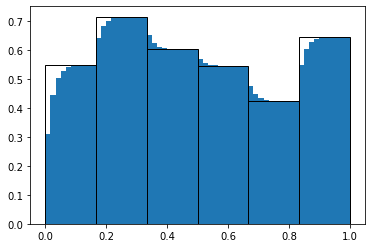

In [1]:
from qopt import *
import numpy as np
n_time_steps = 6
delta_t = 1 / n_time_steps
oversampling = 10


exponential_tf = ExponentialMTF(
    awg_rise_time=.02,
    num_ctrls=1,
    oversampling=oversampling
)

np.random.seed(0)
random_pulse = np.random.rand(n_time_steps, 1)
# If we use the transfer function on its own, we have to set
# the time steps manually.
exponential_tf.set_times(delta_t * np.ones(n_time_steps))
exponential_tf.plot_pulse(random_pulse)


The oversampling creates a pulse on smaller time steps. We can also introduce a boundary behaviour to our pulses to simulate the behavior of our system in a longer algorithm.

Setting the bound type to `bound_type=('n', 5)` means that we simulate five additional time step after the oversampling. Other possible bound types include adding time steps only to the end of the pulse with `bound_type=('right_n', 5)` or to add time steps before the oversampling `bound_type=('x', 5)`.

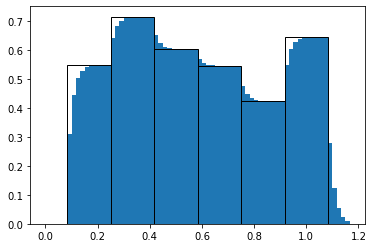

In [2]:
bound_type=('n', 5)

exponential_tf = ExponentialMTF(
    awg_rise_time=.02,
    num_ctrls=1,
    oversampling=oversampling,
    bound_type=bound_type
)

exponential_tf.set_times(delta_t * np.ones(n_time_steps))
exponential_tf.plot_pulse(random_pulse)

Additionally, we can also set an offset to the pulse:

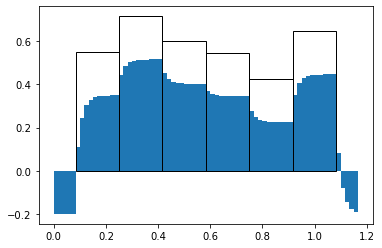

In [3]:
bound_type=('n', 5)

exponential_tf = ExponentialMTF(
    awg_rise_time=.02,
    num_ctrls=1,
    oversampling=oversampling,
    bound_type=bound_type,
    offset=-.2
)

exponential_tf.set_times(delta_t * np.ones(n_time_steps))
exponential_tf.plot_pulse(random_pulse)

Let's now consider a bandwidth limitation that we model by gaussian filtering. We use an efficient implementation as Convolution. The class `GaussianConvolution` does not have an option to include an oversampling or boundaries, but we can concatenate it with an instance of the class `OversamplingTF` for this purpose.

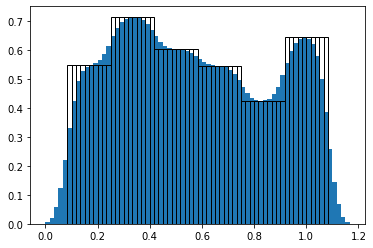

In [4]:
oversampling_tf = OversamplingTF(
    oversampling=oversampling,
    num_ctrls=1,
    bound_type=bound_type
)

gaussian_tf = GaussianConvolution(
    sigma=2,
    num_ctrls=1
)

combined_concatenated = ConcatenateTF(
    tf1=oversampling_tf,
    tf2=gaussian_tf
)

combined_concatenated.set_times(delta_t * np.ones(n_time_steps))
combined_concatenated.plot_pulse(random_pulse)

In a simulation with multiple electronic devices generating different control signals, we might also want to apply several transfer functions in parallel. Note that in this case the transfer functions must operate within a common time frame, meaning they need to expect the same number of time steps and return a signal with the same number of time steps.

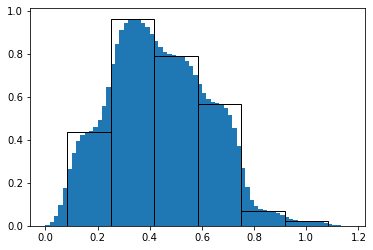

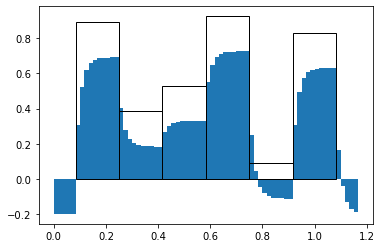

In [5]:
combined_parallel = ParallelTF(
    tf1=combined_concatenated,
    tf2=exponential_tf
)

# Resetting the bound type is only necessary for plotting.
# The flexibility of the transfer function class allows combining
# transfer functions with bound types that are compatible but not identical.
combined_parallel.bound_type = bound_type

combined_parallel.set_times(delta_t * np.ones(n_time_steps))
combined_parallel.plot_pulse(np.random.rand(n_time_steps, 2))


If we use the transfer function in our solver, then we do not need to set the time steps ourselves.

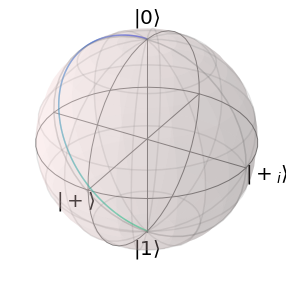

In [6]:
sigma_x = DenseOperator.pauli_x()
sigma_y = DenseOperator.pauli_y()
sigma_z = DenseOperator.pauli_z()
zero_matrix = DenseOperator(np.zeros((2, 2)))

delta_omega = 0
n_time_steps = 6
total_time = 1

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [delta_omega * .5 * sigma_z] * (n_time_steps * oversampling + 2 * 5)

time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

control_amplitudes = np.zeros((n_time_steps, len(h_ctrl)))
control_amplitudes[:, 0] = np.pi

solver = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=time_steps,
    transfer_function=combined_parallel
)

solver.set_optimization_parameters(control_amplitudes)
solver.plot_bloch_sphere()

Note that a time-dependent drift Hamiltonian now needs an element for every time step on the oversampled time-scale including boundary time steps.

If you are curious how you can characterise your experimental setup and extract a valid transfer function based on measurement data, then check out the [qopt-applications](https://github.com/qutech/qopt-applications) repository on GitHub.